## MNISTを使った数字認識

これまでの例題はPyTorchの使い方を知るための単なる例題で、一般的に「深層学習」と呼ばれているモノではない。

深層学習は、隠れ層の数が２層以上のモノをいい、隠れ層同士の間には、活性化関数（レイヤ関数とも）と呼ばれる、
非線形関数を挟む（他の非線形関数はp.138、表4-1にある）。

非線形関数を挟まないと、隠れ層の層数をいくら増やそうが、１階層のモデルと等価である。

以下の例は、計算が非常に重いので**Google Colabo上でGPUを使って走らせる**ことを想定している。

### 活性化関数

まず、活性化関数について、おさらいする。

In [1]:
! pip install japanize_matplotlib 2> /dev/null | tail -1

In [2]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

random_seed = 123

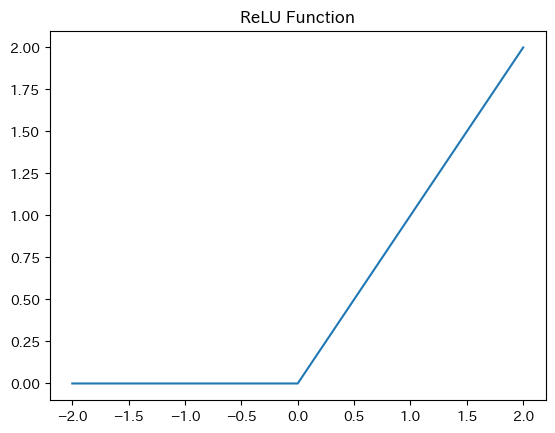

In [3]:
relu = nn.ReLU()

x_np = np.arange(-2, 2.1, 0.25)
x = torch.tensor(x_np).float()
y = relu(x)

plt.plot(x.data, y.data)
plt.title('ReLU Function')
plt.show()

Definition of Rectified Linear Unit, i.e., ReLU, function is

$f(x) =
\left\{
\begin{array}{cr}
0,\hspace{0.5cm} x \leq 0, \\
x,\hspace{0.5cm} x \gt 0.
\end{array}
\right.$

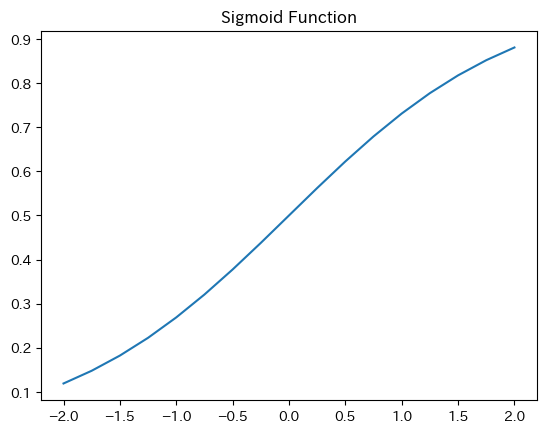

In [4]:
sigmoid = nn.Sigmoid()
y = sigmoid(x)

plt.plot(x.data, y.data)
plt.title('Sigmoid Function')
plt.show()

Definition of sigmoid function is

$f(x) = \cfrac{1}{1 - \exp{\left(-x\right)}}$

which is used to transform a scalar value into some probability.

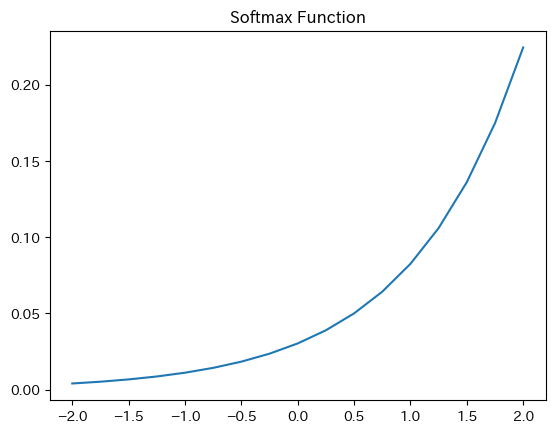

In [5]:
#softmax = nn.Softmax() # Implicit dimension choice for softmax has been deprecated. we have to specify `dim` keyword variable as follows.
softmax = nn.Softmax(dim=0)
y = softmax(x)

plt.plot(x.data, y.data)
plt.title('Softmax Function')
plt.show()

Definition of softmax function is

$y_i = \cfrac{\exp{\left(x_i\right)}}{\sum_{k=1}^n\exp{\left(x_k\right)}}$

which is obviously used for multiple-class classification.

### GPUの設定

Google Colaboのメニューで Runtime > Change running typeからT4 GPUを選択する。

以下でGPUが使われていることを確認する。

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(f'device count: {torch.cuda.device_count()}')
print(f'device name: {torch.cuda.get_device_name()}')
print(f'device capability: {torch.cuda.get_device_capability()}')

cuda:0
device count: 1
device name: Tesla T4
device capability: (7, 5)


In [7]:
import os

key = 'CUDA_VISIBLE_DEVICES'

if key in os.environ:
  print(f'{key}: {os.environ[key]}')
else:
  print(f'"{key}" is not defined as environment variable')

# when CUDA_VISIBLE_DEVICES env is set to -1, use of GPU is refrained even if it is available

"CUDA_VISIBLE_DEVICES" is not defined as environment variable


TensorFlowではKerasを用いて、GPUとCPUの処理を意識せずに走らせることができる。

PyTorchは、コードを書く時点で、ユーザが手動で制御しないといけない。各テンソルは
CPU上か、GPU上か、という状態をもち、同じ状態をもつテンソル同士しか計算できない。
異なる状態の場合は、エラーになる！

In [8]:
x_np = np.arange(-2, 2.1, 0.25)
y_np = np.arange(-2, 2.1, 0.25)
x = torch.tensor(x_np).float()
y = torch.tensor(y_np).float()

z = x * y
z

tensor([4.0000, 3.0625, 2.2500, 1.5625, 1.0000, 0.5625, 0.2500, 0.0625, 0.0000,
        0.0625, 0.2500, 0.5625, 1.0000, 1.5625, 2.2500, 3.0625, 4.0000])

In [9]:
x.to(device) # This is not destructive method

z = x * y
z

tensor([4.0000, 3.0625, 2.2500, 1.5625, 1.0000, 0.5625, 0.2500, 0.0625, 0.0000,
        0.0625, 0.2500, 0.5625, 1.0000, 1.5625, 2.2500, 3.0625, 4.0000])

In [10]:
x = x.to(device)

z = x * y
z

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

モデルのインスタンスに関しても、テンソルと同様、CPU上か、GPU上かを明示的に指定する。

### データの読み込み

In [11]:
import torchvision.datasets as datasets

data_root = './data'

mnist_train = datasets.MNIST(root=data_root, train=True, download=True)
mnist_test = datasets.MNIST(root=data_root, train=False, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4583455.24it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134917.82it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1261810.30it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2994424.52it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [12]:
! ls -lR ./data/MNIST

./data/MNIST:
total 4
drwxr-xr-x 2 root root 4096 Sep 24 04:44 raw

./data/MNIST/raw:
total 65008
-rw-r--r-- 1 root root  7840016 Sep 24 04:44 t10k-images-idx3-ubyte
-rw-r--r-- 1 root root  1648877 Sep 24 04:44 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    10008 Sep 24 04:44 t10k-labels-idx1-ubyte
-rw-r--r-- 1 root root     4542 Sep 24 04:44 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 47040016 Sep 24 04:43 train-images-idx3-ubyte
-rw-r--r-- 1 root root  9912422 Sep 24 04:43 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    60008 Sep 24 04:43 train-labels-idx1-ubyte
-rw-r--r-- 1 root root    28881 Sep 24 04:43 train-labels-idx1-ubyte.gz


In [13]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [14]:
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [15]:
mnist_train[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

28x28の画像と分かる。また、画像にはラベル（回答の数字）が付けられている。

In [16]:
image, label = mnist_train[0]

In [17]:
type(image), type(label)

(PIL.Image.Image, int)

(-0.5, 27.5, 27.5, -0.5)

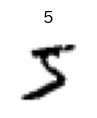

In [18]:
plt.figure(figsize=(1, 1))
plt.title(f'{label}')
plt.imshow(image, cmap='gray_r')
plt.axis('off')

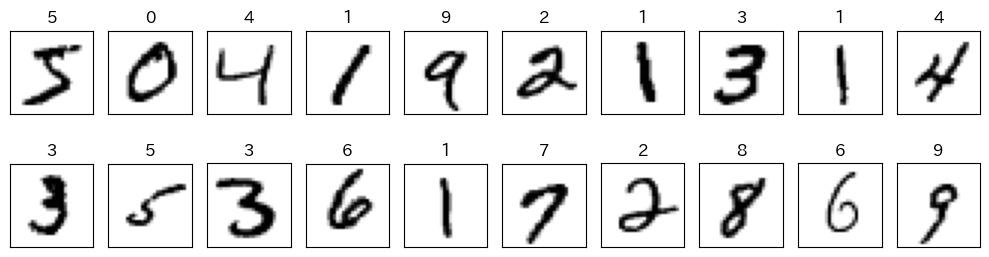

In [19]:
plt.figure(figsize=(10, 3))

for ii in range(20):
  ax = plt.subplot(2, 10, ii + 1)
  image, label = mnist_train[ii]
  plt.title(f'{label}')
  plt.imshow(image, cmap='gray_r')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.tight_layout()

### データ前処理

In [20]:
import torchvision.transforms as transforms

transform1 = transforms.Compose([
    transforms.ToTensor(),
    ])

train_set = datasets.MNIST(root=data_root, train=True, download=True, transform=transform1)


In [21]:
image, label = train_set[0]

print(f'type: {type(image)}, shape: {image.shape}, Min: {image.data.min()}, Max: {image.data.max()}')

type: <class 'torch.Tensor'>, shape: torch.Size([1, 28, 28]), Min: 0.0, Max: 1.0


画像データを $[0, 1]$ に変換

In [22]:
transform2 = transforms.Compose([
    # テンソル化
    transforms.ToTensor(),
    # [0, 1] に正規化
    transforms.Normalize(0.5, 0.5),
    ])

train_set = datasets.MNIST(root=data_root, train=True, download=True, transform=transform2)

In [23]:
image, label = train_set[0]

print(f'type: {type(image)}, shape: {image.shape}, Min: {image.data.min()}, Max: {image.data.max()}')

type: <class 'torch.Tensor'>, shape: torch.Size([1, 28, 28]), Min: -1.0, Max: 1.0


画像データを $[-1, 1]$ に変換

In [24]:
transform3 = transforms.Compose([
    # テンソル化
    transforms.ToTensor(),
    # [0, 1] に正規化
    transforms.Normalize(0.5, 0.5),
    # １階テンソル化
    transforms.Lambda(lambda x: x.view(-1)),
    ])

train_set = datasets.MNIST(root=data_root, train=True, download=True, transform=transform3)

In [25]:
image, label = train_set[0]

print(f'type: {type(image)}, shape: {image.shape}, Min: {image.data.min()}, Max: {image.data.max()}')

type: <class 'torch.Tensor'>, shape: torch.Size([784]), Min: -1.0, Max: 1.0


２階テンソル（画像）を１階テンソルに変換

In [26]:
test_set = datasets.MNIST(root=data_root, train=False, download=True, transform=transform3)

In [27]:
image, label = test_set[0]

print(f'type: {type(image)}, shape: {image.shape}, Min: {image.data.min()}, Max: {image.data.max()}')

type: <class 'torch.Tensor'>, shape: torch.Size([784]), Min: -1.0, Max: 1.0


In [28]:
from torch.utils.data import DataLoader

batch_size = 500

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [29]:
print(len(train_loader))

for images, labels in train_loader:
  print(f'images: {images.shape}, labels: {labels.shape}')
  break

120
images: torch.Size([500, 784]), labels: torch.Size([500])


In [30]:
n_input = image.shape[0]
n_output = 10
n_hidden = 128

print(f'#input: {n_input}, #hidden: {n_hidden}, #output: {n_output}')

#input: 784, #hidden: 128, #output: 10


### モデル定義

In [60]:
class Net(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Net, self).__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        self.relu = nn.ReLU(inplace=True)
        self.l2 = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        return x


In [61]:
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

lr = 0.01
net = Net(n_input, n_hidden, n_output)
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
num_epochs = 100
history = np.zeros((0,5))

In [62]:
for parameter in net.named_parameters():
  print(parameter)

('l1.weight', Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0277,  0.0200,  0.0315],
        [ 0.0184, -0.0322,  0.0175,  ...,  0.0089, -0.0028, -0.0033],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0322, -0.0059, -0.0169],
        [-0.0328, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       device='cuda:0', requires_grad=True))
('l1.bias', Parameter containing:
tensor([ 0.0325, -0.0298,  0.0013,  0.0199,  0.0268, -0.0248, -0.0172, -0.0355,
         0.0122, -0.0048,  0.0214,  0.0202, -0.0243,  0.0015, -0.0276,  0.0296,
         0.0341, -0.0228,  0.0230,  0.0347, -0.0091, -0.0346,  0.0206, -0.0060,
         0.0329,  0.0047,  0.0180,  0.0101,  0.0177, -0.0309,  0.0228, -0.0224,
         0.0321,  0.0179,  0.0321,  0.0184,  0.0219, -0.0089,  0.0310, -0.0039,
        -0.0074, -0.0317,  0.0192, -0.0021,  0.0190

In [63]:
print(net)

Net(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU(inplace=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
)


In [64]:
for images, labels in train_loader:
  break

inputs = images.to(device)
labels = labels.to(device)
outputs = net(inputs)
print(outputs)

tensor([[-0.2908, -0.0540,  0.0845,  ...,  0.0779,  0.1828,  0.1080],
        [-0.2764, -0.3271, -0.1788,  ...,  0.1037,  0.1030, -0.0235],
        [-0.3289, -0.0409,  0.1447,  ...,  0.3945,  0.2317,  0.1213],
        ...,
        [-0.4067, -0.0062,  0.1470,  ...,  0.0346,  0.1045,  0.1304],
        [-0.3684, -0.2211,  0.1907,  ...,  0.0544,  0.2114,  0.1275],
        [-0.2524, -0.2597,  0.1427,  ...,  0.0983,  0.1258,  0.0972]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [65]:
! pip install torchviz 2> /dev/null | tail -1

2.3259594440460205


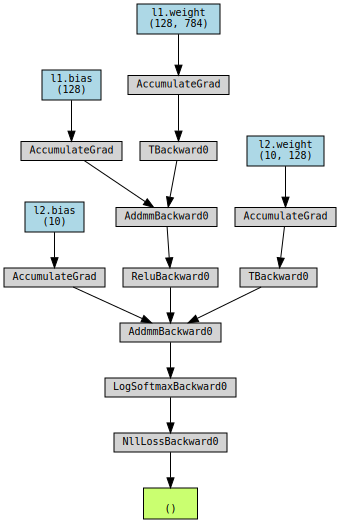

In [66]:
loss = criterion(outputs, labels)
print(loss.item())

from torchviz import make_dot

make_dot(loss, params=dict(net.named_parameters()))

In [67]:
from tqdm.notebook import tqdm

In [68]:
for epoch in range(num_epochs):
  train_acc, val_acc = 0, 0
  train_loss, val_loss = 0, 0
  n_train, n_test = 0, 0

  ### train phase ###
  for inputs, labels in tqdm(train_loader):
    train_batch_size = len(labels)
    n_train += train_batch_size

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    predicted = torch.max(outputs, 1)[1]
    train_acc += (predicted == labels).sum().item()
    train_loss += loss.item() * train_batch_size

  train_acc /= n_train
  train_loss /= n_train

  ### test phase ###
  for inputs_test, labels_test in test_loader:
    test_batch_size = len(labels_test)
    n_test += test_batch_size

    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    outputs_test = net(inputs_test)
    loss_test = criterion(outputs_test, labels_test)

    predict_test = torch.max(outputs_test, 1)[1]
    val_acc += (predict_test == labels_test).sum().item()
    val_loss += loss_test.item() * test_batch_size

  val_acc /= n_test
  val_loss /= n_test

  print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
  item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
  history = np.vstack((history, item))

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [0/100], loss: 1.82967 acc: 0.57072 val_loss: 1.32895, val_acc: 0.74410


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1/100], loss: 1.03997 acc: 0.79540 val_loss: 0.79890, val_acc: 0.83360


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2/100], loss: 0.70843 acc: 0.84067 val_loss: 0.60303, val_acc: 0.85930


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3/100], loss: 0.57306 acc: 0.86038 val_loss: 0.51224, val_acc: 0.87120


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4/100], loss: 0.50232 acc: 0.87173 val_loss: 0.45818, val_acc: 0.87920


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.45882 acc: 0.87845 val_loss: 0.42437, val_acc: 0.88620


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.42949 acc: 0.88355 val_loss: 0.40053, val_acc: 0.89150


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.40812 acc: 0.88790 val_loss: 0.38252, val_acc: 0.89370


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.39166 acc: 0.89070 val_loss: 0.36806, val_acc: 0.89660


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.37855 acc: 0.89387 val_loss: 0.35773, val_acc: 0.89900


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.36803 acc: 0.89550 val_loss: 0.34861, val_acc: 0.90100


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.35906 acc: 0.89807 val_loss: 0.33995, val_acc: 0.90410


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.35120 acc: 0.89982 val_loss: 0.33403, val_acc: 0.90610


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.34433 acc: 0.90153 val_loss: 0.32778, val_acc: 0.90630


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.33856 acc: 0.90303 val_loss: 0.32331, val_acc: 0.90780


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.33308 acc: 0.90445 val_loss: 0.31763, val_acc: 0.90860


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.32820 acc: 0.90563 val_loss: 0.31390, val_acc: 0.90990


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.32351 acc: 0.90683 val_loss: 0.30983, val_acc: 0.91220


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.31936 acc: 0.90808 val_loss: 0.30689, val_acc: 0.91120


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.31524 acc: 0.90942 val_loss: 0.30248, val_acc: 0.91390


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.31167 acc: 0.91003 val_loss: 0.29941, val_acc: 0.91510


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.30803 acc: 0.91123 val_loss: 0.29629, val_acc: 0.91500


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.30456 acc: 0.91240 val_loss: 0.29393, val_acc: 0.91530


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.30145 acc: 0.91365 val_loss: 0.29059, val_acc: 0.91850


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.29845 acc: 0.91432 val_loss: 0.28841, val_acc: 0.91800


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.29546 acc: 0.91538 val_loss: 0.28615, val_acc: 0.91850


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.29253 acc: 0.91637 val_loss: 0.28382, val_acc: 0.91960


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.28974 acc: 0.91702 val_loss: 0.28167, val_acc: 0.91930


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.28712 acc: 0.91800 val_loss: 0.27880, val_acc: 0.92000


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.28444 acc: 0.91895 val_loss: 0.27636, val_acc: 0.92140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.28189 acc: 0.91932 val_loss: 0.27437, val_acc: 0.92300


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.27936 acc: 0.92005 val_loss: 0.27194, val_acc: 0.92210


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.27696 acc: 0.92122 val_loss: 0.27028, val_acc: 0.92340


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.27455 acc: 0.92160 val_loss: 0.26791, val_acc: 0.92320


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.27210 acc: 0.92215 val_loss: 0.26661, val_acc: 0.92450


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.26983 acc: 0.92253 val_loss: 0.26512, val_acc: 0.92490


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.26742 acc: 0.92375 val_loss: 0.26216, val_acc: 0.92580


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.26525 acc: 0.92437 val_loss: 0.26093, val_acc: 0.92660


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.26312 acc: 0.92517 val_loss: 0.25858, val_acc: 0.92610


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.26086 acc: 0.92538 val_loss: 0.25608, val_acc: 0.92710


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.25864 acc: 0.92650 val_loss: 0.25484, val_acc: 0.92700


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.25643 acc: 0.92693 val_loss: 0.25289, val_acc: 0.92860


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.25424 acc: 0.92778 val_loss: 0.25073, val_acc: 0.92810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.25212 acc: 0.92780 val_loss: 0.24851, val_acc: 0.92950


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.25012 acc: 0.92873 val_loss: 0.24719, val_acc: 0.93020


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.24800 acc: 0.92945 val_loss: 0.24537, val_acc: 0.92990


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.24600 acc: 0.92962 val_loss: 0.24374, val_acc: 0.93120


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.24391 acc: 0.93053 val_loss: 0.24177, val_acc: 0.93100


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.24193 acc: 0.93132 val_loss: 0.23953, val_acc: 0.93240


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.23995 acc: 0.93163 val_loss: 0.23814, val_acc: 0.93230


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.23797 acc: 0.93228 val_loss: 0.23601, val_acc: 0.93300


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.23593 acc: 0.93307 val_loss: 0.23538, val_acc: 0.93340


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.23411 acc: 0.93360 val_loss: 0.23229, val_acc: 0.93430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.23224 acc: 0.93440 val_loss: 0.23124, val_acc: 0.93430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.23026 acc: 0.93528 val_loss: 0.22949, val_acc: 0.93500


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.22833 acc: 0.93523 val_loss: 0.22754, val_acc: 0.93560


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.22655 acc: 0.93627 val_loss: 0.22587, val_acc: 0.93610


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.22478 acc: 0.93657 val_loss: 0.22392, val_acc: 0.93640


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.22293 acc: 0.93713 val_loss: 0.22291, val_acc: 0.93690


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.22106 acc: 0.93777 val_loss: 0.22144, val_acc: 0.93720


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.21937 acc: 0.93802 val_loss: 0.21927, val_acc: 0.93750


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.21762 acc: 0.93893 val_loss: 0.21770, val_acc: 0.93820


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.21587 acc: 0.93933 val_loss: 0.21646, val_acc: 0.93890


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.21420 acc: 0.93967 val_loss: 0.21438, val_acc: 0.93800


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.21247 acc: 0.94048 val_loss: 0.21257, val_acc: 0.93860


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.21089 acc: 0.94037 val_loss: 0.21140, val_acc: 0.93920


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.20915 acc: 0.94090 val_loss: 0.21033, val_acc: 0.93970


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.20753 acc: 0.94175 val_loss: 0.20802, val_acc: 0.94050


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.20602 acc: 0.94222 val_loss: 0.20714, val_acc: 0.94060


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.20428 acc: 0.94235 val_loss: 0.20538, val_acc: 0.94160


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.20281 acc: 0.94305 val_loss: 0.20437, val_acc: 0.94140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.20125 acc: 0.94335 val_loss: 0.20299, val_acc: 0.94090


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.19978 acc: 0.94332 val_loss: 0.20190, val_acc: 0.94210


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.19823 acc: 0.94435 val_loss: 0.20055, val_acc: 0.94140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.19691 acc: 0.94428 val_loss: 0.19879, val_acc: 0.94320


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.19539 acc: 0.94508 val_loss: 0.19709, val_acc: 0.94350


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.19407 acc: 0.94512 val_loss: 0.19625, val_acc: 0.94320


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.19257 acc: 0.94588 val_loss: 0.19475, val_acc: 0.94260


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.19108 acc: 0.94608 val_loss: 0.19362, val_acc: 0.94330


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.18959 acc: 0.94688 val_loss: 0.19228, val_acc: 0.94370


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.18828 acc: 0.94713 val_loss: 0.19110, val_acc: 0.94430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.18697 acc: 0.94735 val_loss: 0.18948, val_acc: 0.94520


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.18561 acc: 0.94818 val_loss: 0.18823, val_acc: 0.94540


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.18429 acc: 0.94818 val_loss: 0.18757, val_acc: 0.94480


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.18299 acc: 0.94907 val_loss: 0.18603, val_acc: 0.94550


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.18165 acc: 0.94885 val_loss: 0.18491, val_acc: 0.94590


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.18045 acc: 0.94960 val_loss: 0.18370, val_acc: 0.94700


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.17923 acc: 0.94985 val_loss: 0.18236, val_acc: 0.94770


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.17800 acc: 0.95035 val_loss: 0.18162, val_acc: 0.94760


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.17672 acc: 0.95047 val_loss: 0.17992, val_acc: 0.94780


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.17555 acc: 0.95083 val_loss: 0.17950, val_acc: 0.94730


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.17446 acc: 0.95112 val_loss: 0.17800, val_acc: 0.94790


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.17322 acc: 0.95138 val_loss: 0.17670, val_acc: 0.94880


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.17199 acc: 0.95207 val_loss: 0.17643, val_acc: 0.94760


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.17092 acc: 0.95238 val_loss: 0.17552, val_acc: 0.94730


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.16986 acc: 0.95258 val_loss: 0.17439, val_acc: 0.94920


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.16879 acc: 0.95277 val_loss: 0.17269, val_acc: 0.94960


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.16755 acc: 0.95312 val_loss: 0.17211, val_acc: 0.94970


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.16651 acc: 0.95347 val_loss: 0.17137, val_acc: 0.94890


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.16555 acc: 0.95398 val_loss: 0.17055, val_acc: 0.94950


Text(0, 0.5, 'Loss')

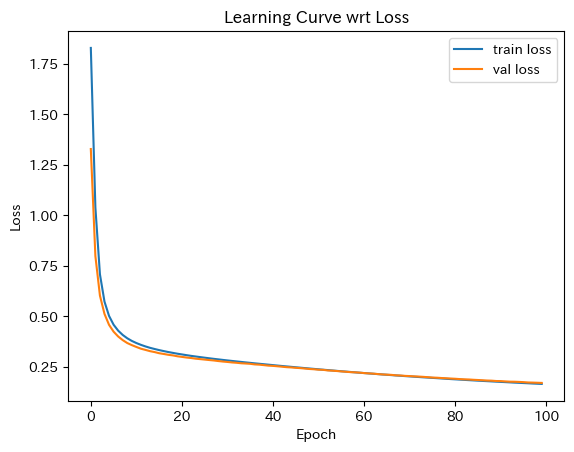

In [72]:
plt.plot(history[:, 0], history[:, 1], label='train loss')
plt.plot(history[:, 0], history[:, 3], label='val loss')
plt.legend()
plt.title('Learning Curve wrt Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

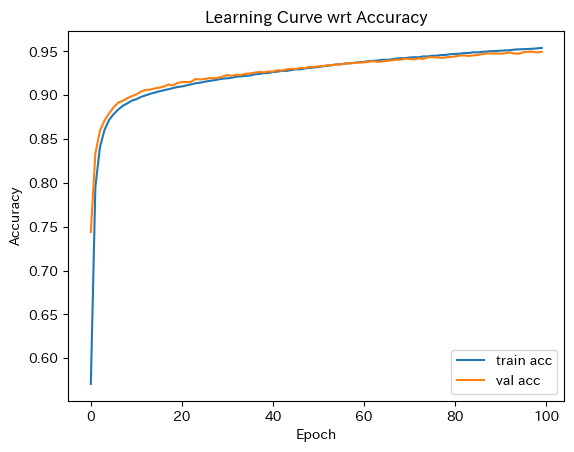

In [71]:
plt.plot(history[:, 0], history[:, 2], label='train acc')
plt.plot(history[:, 0], history[:, 4], label='val acc')
plt.legend()
plt.title('Learning Curve wrt Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')